In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import dask
import os, sys
import glob
import zarr
from joblib import Parallel, delayed
import os
import dask.array as da
import matplotlib.pyplot as plt

sys.path.append('/')
from libraries import *

dates = pd.date_range(start='2011-01-01T00', end='2020-12-31T23', freq='h')
wind_speed_zarr_store = '/media/harish/External_3/CERRA_wind_profiles_and_Chebyshev_coefficients/CERRA_height_level_winds.zarr'
Cheybshev_zarr_store = '/data/harish/CERRA_wind_profiles_and_Chebyshev_coefficients/CERRA_Chebyshev_coefficients.zarr'

In [2]:
print("Starting parallel computing...")
import dask.distributed as dd
cluster = dd.LocalCluster(n_workers=128,threads_per_worker=1,memory_limit='4GB',dashboard_address='8787')
# Connect to the cluster
client = dd.Client(cluster)
print(client)

Starting parallel computing...
<Client: 'tcp://127.0.0.1:36801' processes=128 threads=128, memory=476.84 GiB>


In [3]:
# Open the Zarr store
wind_speed_store = zarr.open(wind_speed_zarr_store, mode="r")
print(wind_speed_store.tree())

# Select dimensions
time_dim = wind_speed_store["time"]
height_dim = wind_speed_store["heightAboveGround"]
print(wind_speed_store.wind_speed.chunks)

import itertools
chunk_sizes = wind_speed_store.wind_speed.chunks
# Compute all chunk indices
num_chunks = [dim // chunk_size + (dim % chunk_size > 0) for dim, chunk_size in zip(wind_speed_store.wind_speed.shape, chunk_sizes)]
all_chunks = list(itertools.product(*[range(nc) for nc in num_chunks]))
print("Total chunks:", len(all_chunks))
print("Chunks correspond to 24 hours (1 time chunk) along x and y:", all_chunks[:25])

/
 ├── heightAboveGround (12,) float64
 ├── time (87672,) int64
 └── wind_speed (87672, 1069, 1069, 12) float32
(24, 256, 256, 12)
Total chunks: 91325
Chunks correspond to 24 hours (1 time chunk) along x and y: [(0, 0, 0, 0), (0, 0, 1, 0), (0, 0, 2, 0), (0, 0, 3, 0), (0, 0, 4, 0), (0, 1, 0, 0), (0, 1, 1, 0), (0, 1, 2, 0), (0, 1, 3, 0), (0, 1, 4, 0), (0, 2, 0, 0), (0, 2, 1, 0), (0, 2, 2, 0), (0, 2, 3, 0), (0, 2, 4, 0), (0, 3, 0, 0), (0, 3, 1, 0), (0, 3, 2, 0), (0, 3, 3, 0), (0, 3, 4, 0), (0, 4, 0, 0), (0, 4, 1, 0), (0, 4, 2, 0), (0, 4, 3, 0), (0, 4, 4, 0)]


# Initializing a zarr by reading sample data
- Once created, no need to repeat again.

In [4]:
def init_zarr_store(zarr_store, dates):
    template = xr.open_zarr(wind_speed_zarr_store).wind_speed.pipe(xr.zeros_like).isel(time=0,heightAboveGround=0,
                                                                            drop=True).expand_dims(time=len(dates), coeff=poly_order+1)
    template['time'] = dates
    template = template.chunk({'time': 24,'y':256,'x':256,'coeff':5})
    template = template.transpose('time','y','x','coeff')
    template.to_dataset(name = 'Chebyshev_coefficients').to_zarr(zarr_store, compute=False, consolidated=True, mode='w')
'''
Initialize the zarr store, which creates the zarr store in disk, with zeros. 
Once created, better to chose append mode for further operations or else it will overwrite the existing data.
'''
#init_zarr_store(Cheybshev_zarr_store, dates)

'\nInitialize the zarr store, which creates the zarr store in disk, with zeros. \nOnce created, better to chose append mode for further operations or else it will overwrite the existing data.\n'

In [5]:
def write_chunk(ds_chunk, zarr_store, region):
    """
    Function to write a single chunk to the Zarr store.
    """
    ds_chunk.to_zarr(zarr_store, region=region, mode="r+")

def write_to_zarr_parallel(ds, zarr_store, n_jobs=os.cpu_count()):
    """
    Writes the dataset to the Zarr store in parallel using joblib.
    """
    # Determine the time and height indices
    time_indices_monthly = np.searchsorted(dates.values, ds.time.values)
    start,end = time_indices_monthly[0],time_indices_monthly[-1]
    batch_size = 24

    # List to store all tasks
    tasks = []

    # Iterate over time indices in batches
    for t_idx in range(start, end + 1, batch_size):
        # Calculate the batch range (start to end within bounds)
        batch_end = min(t_idx + batch_size, end + 1)

        # Define the region for this batch
        region = {
            "time": slice(t_idx, batch_end),
        }

        # Select the batch of data
        ds_chunk = (
            ds.sel(time=dates[t_idx:batch_end])
            .to_dataset(name="Chebyshev_coefficients")
        ).drop(['time'])
        # Add the task to the task list
        tasks.append(delayed(write_chunk)(ds_chunk, zarr_store, region))

    # Run all tasks in parallel
    with Parallel(n_jobs=n_jobs, verbose=10) as parallel:
        parallel(tasks)

In [ ]:
for year in range(2015,2011,-1):
    for month in range(1,13):
        s_time = time.time()
        # Load the Zarr dataset and subset for one time step
        ds = xr.open_zarr(wind_speed_zarr_store).wind_speed.sel(time=(f'{year}-{month:02d}'))
        print(ds.time.values[0],ds.time.values[-1])
        # Compute the Chebyshev coefficients
        ds_chebyshev = chebyshev_vec(ds, dim="heightAboveGround").load()
        # save the Chebyshev coefficients to the Zarr store
        write_to_zarr_parallel(ds_chebyshev, Cheybshev_zarr_store, n_jobs=128)
        print("Time taken for month:",time.time()-s_time)

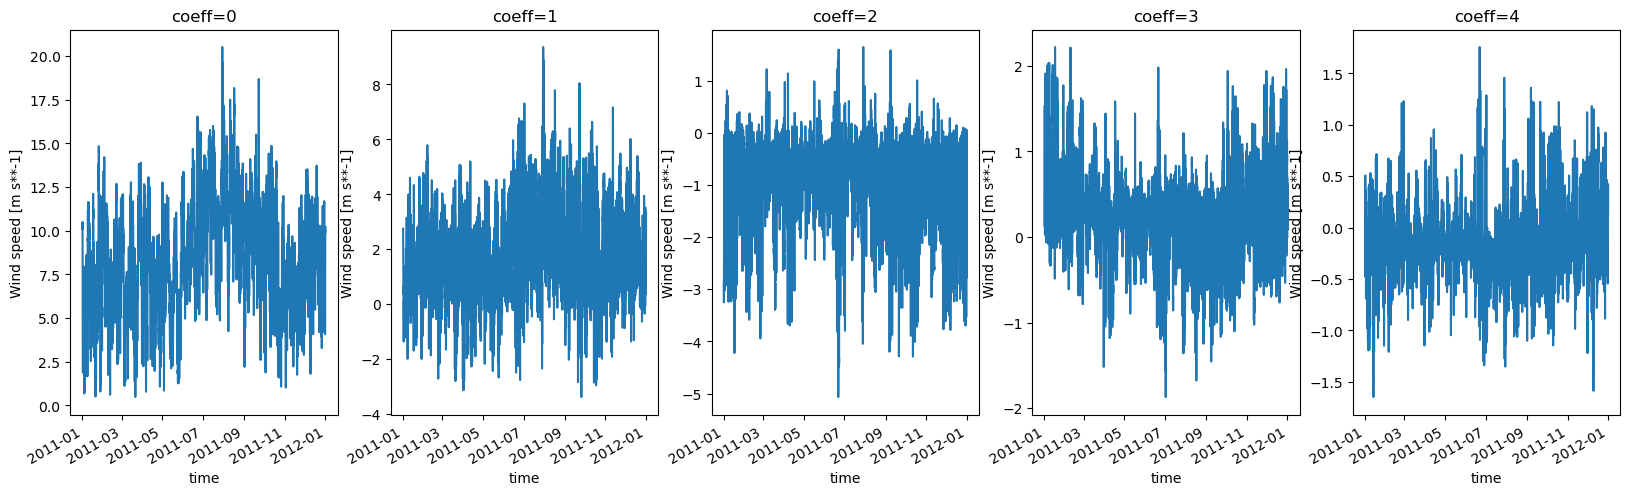

In [2]:
# create five subplots
fig, axs = plt.subplots(1, 5, figsize=(20, 5))
for i,ax in enumerate(axs):
    xr.open_zarr(Cheybshev_zarr_store).Chebyshev_coefficients.sel(time='2011').isel(y=100,x=100,coeff=i).plot(ax=ax)
    ax.set_title(f'coeff={i}')

In [76]:
sample_points = xr.open_dataset('sample_points.nc')
CERRA_coordinates = xr.open_dataset('CERRA_coordinates.nc')

'''
The longitude in sample points are in the range of 0 to 360, whereas the CERRA coordinates are in the range of -180 to 180.
So, we need to convert the longitude in sample points to the same range as CERRA coordinates.
'''
sample_points['longitude'] = (sample_points['longitude']+ 180) % 360 - 180

def find_nearest_indice(ds_lat,ds_lon,target_lat=None, target_lon=None):
    '''
    ds_lat: xarray DataArray of latitude
    ds_lon: xarray DataArray of longitude
    target_lat: float, target latitude
    target_lon: float, target longitude
    returns indices: tuple of indices of the nearest grid point
    '''
    distance_squared = (ds_lat - target_lat)**2 + (ds_lon - target_lon)**2
    indices = np.unravel_index(np.nanargmin(distance_squared), distance_squared.shape)
    #print(f'Closest indices in the order of latitude (y) and longitude (x) are : {indices}')
    return indices

indices = [
    find_nearest_indice(CERRA_coordinates.latitude, CERRA_coordinates.longitude, lat.item(), lon.item())
    for lat, lon in zip(sample_points.latitude, sample_points.longitude)
]
# Split the list of tuples into separate lists for y and x indices
y_indices, x_indices = zip(*indices)
sample_ys = xr.DataArray(np.array(y_indices), dims="points")
sample_xs = xr.DataArray(np.array(x_indices), dims="points")

# Extract the Chebyshev coefficients for the sample points
ds = xr.open_zarr(Cheybshev_zarr_store).Chebyshev_coefficients.sel(time='2020').isel(y=sample_ys,x=sample_xs)
ds.coords['latitude'] = sample_points.latitude
ds.coords['longitude'] = sample_points.longitude
ds.coords['points'] = [f'P{i+1}' for i in range(len(sample_points.longitude))]
ds.to_netcdf('European_region_sample_CERRA_Chebyshev_coefficients.nc')